# Global and Local Explanation for XGBoost model on PTB data


In [9]:
import sys
import os
data_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install tensorflow -q
    !pip install keras -q
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install matplotlib -q
    !pip install umap-learn -q
    !pip install lightgbm
    !pip install xgboost

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your own google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path
else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'
    model_output_path = '../models/'

Path = dict({
    'ptbdb_normal': data_path ,
    'ptbdb_abnormal':  data_path,
})

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


In [14]:
# Verify installation and import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
import pickle
from xgboost import plot_importance, XGBClassifier
import shap
import lime
import lime.lime_tabular


In [11]:
# Load
ptbdb_train = pd.read_csv('../data/processed/ptb_train_clean_standard_oversampling.csv')
ptbdb_test = pd.read_csv('../data/processed/ptb_test_clean_standard_oversampling.csv')

# Remove Dublicates
ptbdb_train = ptbdb_train.drop_duplicates()
ptbdb_test = ptbdb_test.drop_duplicates()

# Split data into features and target
X_train = ptbdb_train.drop(columns=['target'])
y_train = ptbdb_train['target']
X_test = ptbdb_test.drop(columns=['target'])
y_test = ptbdb_test['target']

# Define the model path
current_dir = os.getcwd()
model_path = os.path.join(current_dir, '..', 'models', 'model_ptb_XGBoost.pkl')



## load model

In [12]:
xgb_model = pipeline_model.named_steps.get('xgb', None)
if xgb_model is None:
    print("XGBoost model step not found in pipeline. Please check the pipeline step name.")


In [ ]:
# # Load the XGBoost model (wrapped inside a pipeline)
# model_path = model_output_path + 'model_ptb_XGBoost.pkl'  
# with open(model_path, 'rb') as file:
#     pipeline_model = pickle.load(file)

# # Check the type of the model (pipeline)
# print(f"Model type: {type(pipeline_model)}")


In [13]:
# Look at the steps of the pipeline
print("Pipeline steps:", pipeline_model.named_steps)
    
# Extract the XGBoost model from the pipeline
xgb_model = pipeline_model.named_steps['xgb']  # Adjust based on the name of the XGBoost step in the pipeline

Pipeline steps: {'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)}


### In the following we apply explanation strategies (Feature Importance, SHAP, LIME) on the raw PTB dataset to explain the most important features within the XGBoost model due to to given strategies:


## Feature Importance

C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_15508\3488736032.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


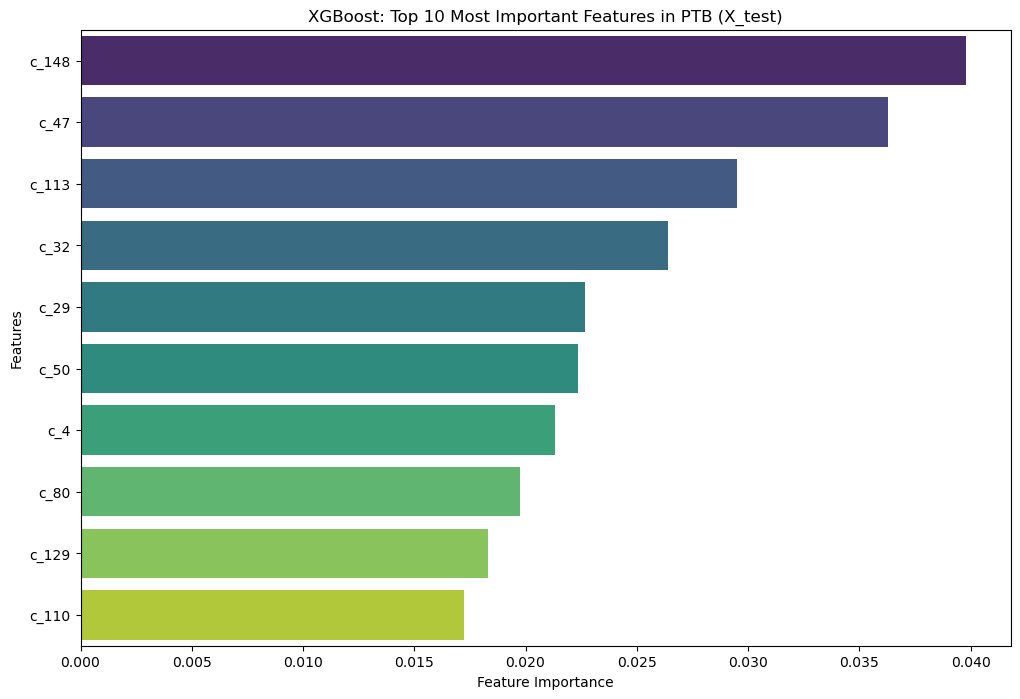

In [15]:
# Get the feature importance values
feature_importance = xgb_model.feature_importances_

# Get the feature names
feature_names = X_test.columns

# Create a DataFrame with feature names and their importance values

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# Sort the DataFrame based on feature importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display the top 10 most important features
top_10_features = feature_importance_df.head(10)
top_10_features

# Display the top 10 least important features
least_10_features = feature_importance_df.tail(10)
least_10_features

# Plot the top 10 most important features
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance', 
    y='feature', 
    data=top_10_features, 
    palette='viridis'
)
plt.title('XGBoost: Top 10 Most Important Features in PTB (X_test)')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

## SHAP

Top 10 most important features based on SHAP values:
    feature  importance
4      c_4    1.052724
32    c_32    1.014775
2      c_2    0.992720
1      c_1    0.957892
7      c_7    0.840817
33    c_33    0.725889
31    c_31    0.648777
34    c_34    0.505264
29    c_29    0.485307
3      c_3    0.456797


C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_15508\1721618112.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


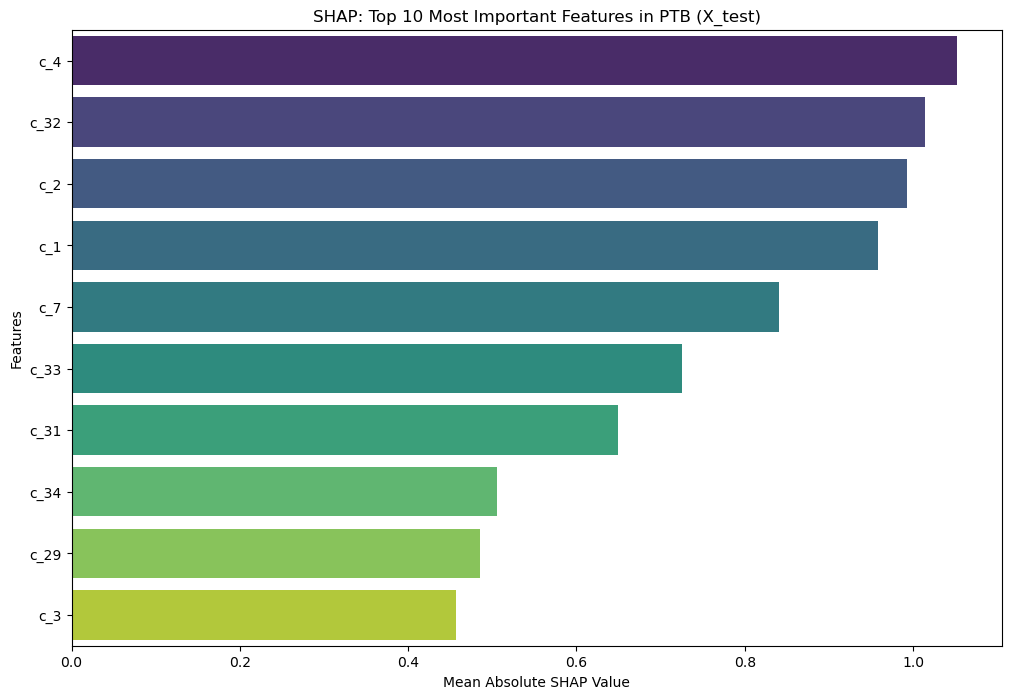

In [ ]:
# SHAP explainer for tree-based models like XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Convert SHAP values to a numpy array and calculate the mean absolute SHAP values for each feature
shap_values_array = shap_values
mean_shap_values = np.abs(shap_values_array).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_shap_values
})

# Sort the DataFrame based on feature importance
shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False)

# Display the top 10 most important features based on SHAP values
top_10_shap_features = shap_importance_df.head(10)
print("Top 10 most important features based on SHAP values:\n", top_10_shap_features)

# Plot the top 10 most important features based on SHAP values
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance', 
    y='feature', 
    data=top_10_shap_features, 
    palette='viridis'
)
plt.title('SHAP: Top 10 Most Important Features in PTB (X_test)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.show()


100%|===================| 2908/2911 [00:17<00:00]        

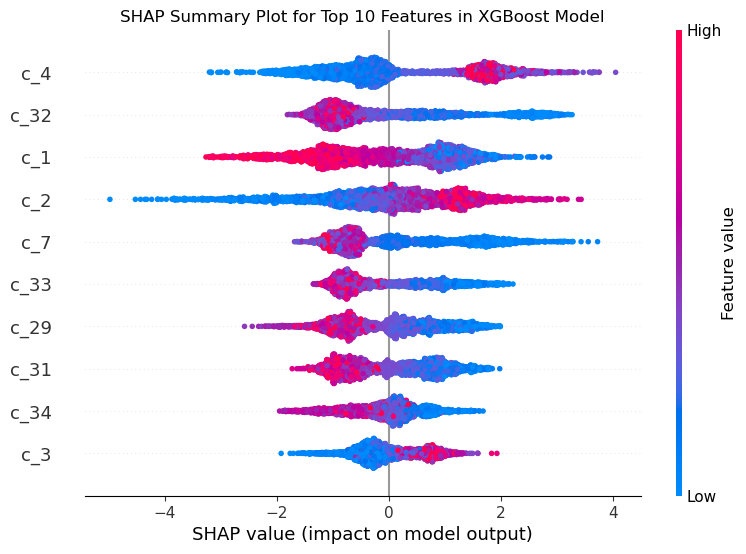

In [18]:
# Generate SHAP values for the entire X_test dataset using TreeExplainer
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Get the top 10 feature names based on importance from the SHAP DataFrame
top_10_feature_names = top_10_shap_features['feature'].values

# Find the indices of the top 10 features in the original dataset
top_10_feature_indices = [X_test.columns.get_loc(feature) for feature in top_10_feature_names]

# Subset the X_test data to only include the top 10 features
X_test_top_10 = X_test[top_10_feature_names]

# Subset the SHAP values for the top 10 features
shap_values_top_10 = shap_values[:, top_10_feature_indices]

# Plot the SHAP summary plot for the top 10 features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_top_10, X_test_top_10, show=False)  # Use `show=False` to modify plot before displaying
plt.title('SHAP Summary Plot for Top 10 Features in XGBoost Model')
plt.show()


## LIME


True Label for selected instance: 0
Instance features:
 c_0     -2.078765
c_1     -1.507747
c_2     -1.261242
c_3     -0.496253
c_4     -0.455642
           ...   
c_182   -0.057988
c_183   -0.049427
c_184   -0.035082
c_185   -0.035330
c_186    0.000000
Name: 200, Length: 187, dtype: float64


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

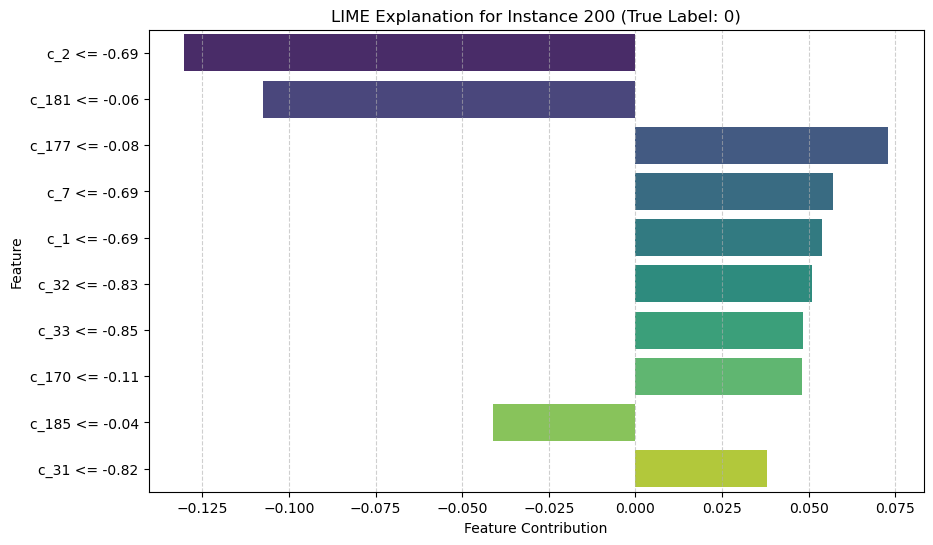

In [19]:
# Create a Lime Explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  # Features from the training data
    training_labels=np.array(y_train),  # Target labels for training data
    mode="classification",  # Set to 'classification' or 'regression' based on your task
    feature_names=X_train.columns,  # Feature names
    class_names=['Class 0', 'Class 1'],  # Class names for binary classification (modify if more classes)
    discretize_continuous=True  # Discretizes continuous features for better explanation
)

# Select a random instance from the test set
idx = 200  ################################  You can change this index to select a different instance! ##############################
instance = X_test.iloc[idx]  # The input instance

# Get the true label for the selected instance
true_label = y_test.iloc[idx]

print("True Label for selected instance:", true_label)
print("Instance features:\n", instance)

# Explain the instance using the LIME explainer
exp = explainer.explain_instance(
    data_row=instance,  # Instance to explain
    predict_fn=pipeline_model.predict_proba,  # Prediction function from the model
    num_features=10  # Number of features to include in the explanation
)

# Extract feature contributions from the explanation object
feature_importance = exp.as_list()  # Returns a list of (feature, contribution) tuples

# Convert the feature importance to a DataFrame for easy visualization
lime_df = pd.DataFrame(feature_importance, columns=['Feature', 'Contribution'])

# Plot the LIME explanation using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Contribution', 
    y='Feature', 
    data=lime_df, 
    palette='viridis', 
    orient='h'
)
plt.title(f'LIME Explanation for Instance {idx} (True Label: {true_label})')
plt.xlabel('Feature Contribution')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [ ]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())